# **Maisy Amelia Silvani**

---

maisyamelia@gmail.com

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.layers import Dense, LSTM, Conv1D
from datetime import datetime, date

In [45]:
df = pd.read_csv("/content/FE_hourly.csv")
df

,Datetime,FE_MW
0,2011-12-31 01:00:00,6222.0
1,2011-12-31 02:00:00,5973.0
2,2011-12-31 03:00:00,5778.0
3,2011-12-31 04:00:00,5707.0
4,2011-12-31 05:00:00,5691.0
...,...,...
62869,2018-01-01 20:00:00,9378.0
62870,2018-01-01 21:00:00,9255.0
62871,2018-01-01 22:00:00,9044.0
62872,2018-01-01 23:00:00,8676.0


In [6]:
df.dtypes

Datetime     object
FE_MW       float64
dtype: object

In [7]:
print("Sample size: ", df.shape)

Sample size:  (62874, 2)


In [47]:
#Check missing values
df.isnull().sum()

Datetime    0
FE_MW       0
dtype: int64

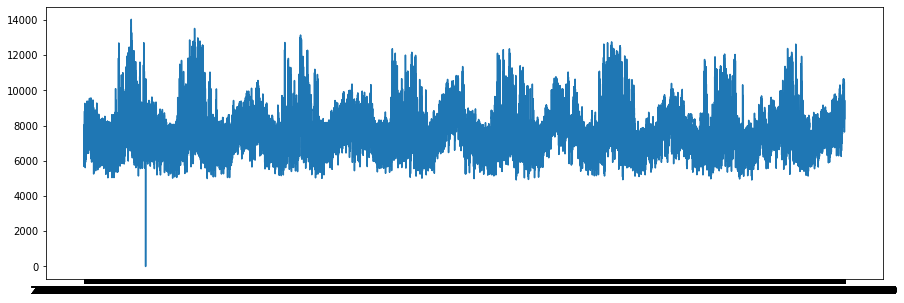

In [8]:
#Plot the data
dates = df["Datetime"].values
FE_MW = df["FE_MW"].values
plt.figure(figsize = (15, 5))
plt.plot(dates, FE_MW)
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(dates, FE_MW, test_size = 0.2, shuffle = False )

In [15]:
print('Data train samples: ',len(x_train))
print('Data validation samples : ',len(x_val))

Data train samples:  50299
Data validation samples :  12575


In [28]:
max = df["FE_MW"].max()
print('Max value : ', max )

Max value :  14032.0


In [30]:
min = df["FE_MW"].min()
print('Min value : ', min )

Min value :  0.0


In [31]:
k = (max-min) * (10/100)
k

1403.2

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [36]:
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
tf.keras.backend.set_floatx('float64')

train_set = windowed_dataset(FE_MW, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_val, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
                tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                strides=1, padding="causal",
                activation="relu",
                input_shape=[None, 1]),
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(1)
])

In [37]:
#Using Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
   if(logs.get('mae')<k and logs.get('val_mae')<k):
        print("MAE < 10% of the datasize, stop training!")
        self.model.stop_training = True
callbacks = myCallback()

In [44]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
train_size = len(x_train)
val_size = len(x_val)
history = model.fit(train_set, 
                    validation_data=val_set, 
                    steps_per_epoch=30, 
                    validation_steps=30, 
                    epochs=100, 
                    callbacks=[callbacks])

Epoch 1/100
30/30 [==============================] - 76s 2s/step - loss: 7121.0691 - mae: 7121.5692 - val_loss: 6626.9671 - val_mae: 6627.4670
Epoch 2/100
30/30 [==============================] - 68s 2s/step - loss: 6579.1974 - mae: 6579.6974 - val_loss: 5921.5669 - val_mae: 5922.0670
Epoch 3/100
30/30 [==============================] - 70s 2s/step - loss: 5655.8556 - mae: 5656.3556 - val_loss: 4587.4826 - val_mae: 4587.9825
Epoch 4/100
30/30 [==============================] - 69s 2s/step - loss: 3776.7779 - mae: 3777.2778 - val_loss: 2190.5997 - val_mae: 2191.0998
Epoch 5/100
30/30 [==============================] - 69s 2s/step - loss: 1392.3788 - mae: 1392.8787 - val_loss: 1134.6704 - val_mae: 1135.1703
MAE < 10% of the datasize, stop training!
